<a href="https://colab.research.google.com/github/Platinum-Dragon/Ore-detector-presentation/blob/main/Ore_Detector_Proof_of_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Algorithm has Promise in Learning to Detect Ore Through Discoloration in Visible Light

Satellite images are already used to identify potential sources of minerals and ore by scanning the images for signature light frequencies that are reflected from the terrain where the ore may be present.

We trained a CNN to recognize terrain containing quartz deposits from satellite images with 66.5% (+/- 1.5%) accuracy.

The idea for this project was inspired by this paper:
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016GC006501
where light signatures were being used to detect the presence of various mineral ores.

Below is the procedure we used.
First, we make sure we have some essential packages installed:

In [ ]:
!pip install pillow
!pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install sklearn

Next, import some necessary packages:

In [2]:
import os
from PIL import Image
import requests
import numpy as np
import pandas as pd



In [ ]:
print(f"TPU address-> grpc://{os.environ['COLAB_TPU_ADDR']}")

TPU address-> grpc://10.13.254.154:8470


Let's mount our Google Drive so that we can store our data and share it if need be, and also define the path that we will store our satellite images in.

This Colab will store a root path in order to know where to look for any files
needed during operation.

If your path is different than:
"/content/drive/My Drive/Colab Notebooks/Ore Detector/"
then you will have to modify it accordingly

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# This is the working directory for this Colab
ROOT_PATH = "/content/drive/My Drive/Colab Notebooks/Ore Detector/"

# provide link to download our image datset.

# These global variables will allow you to change the directories that the 
# satellite images will be written to or the coordinate dataset will be read
# from.
SAT_IMG_DIR = "SatImages/"
LAT_LONG_DIR = "Lat Long Datasets/"


Mounted at /content/drive


Now, let's go get some satellite images. We already have a dataset of latitude and longitude coordinates of known mineral sources, some containing quartz and some not, stored in a csv file. So for each set of coordinates we need to fetch its corresponding image.

To fetch each image, we will be using Google Static Maps API, and you will need an API key to use it.

Here is how to get your API key:https://developers.google.com/maps/documentation/embed/get-api-key

When you have your API key, place it in a folder in the Ore Detector directory called:
"map_apikey" and the Colab will look for it there.

A call to Google Static Maps API will give us our image. The data row already has a column indicating whether there is quartz or not, so we can save the image to the "quartz" directory if it has quartz, and the "notquartz" directory if not.

In [ ]:
# TODO change the key to a constant, provide link explaining how they
# can get their own key and then read key from local folder.

'''
This cell will fetch the satellite image for each of the coordinates listed
in the dataset
'''
# Set this flag to true if the image data needs to be reconstructed again.
BUILD_IMAGE_DATA = False

if BUILD_IMAGE_DATA:
  GOOGLE_STATIC_MAPS_ADDY = "https://maps.googleapis.com/maps/api/staticmap?"
  dfMineral = pd.read_csv(f"{ROOT_PATH}{LAT_LONG_DIR}MagnetiteLatLong.csv")

  # First get the API key for calling Google Maps
  try:
    with open(f"{ROOT_PATH}map_apikey", "r") as f:
      MAPS_API_KEY = f.read()
  except FileNotFoundError:
    print("API key file not found")
    exit(-1)

  # Parameter list for map image call
  picSize = "600x600"
  zoomLevel = 7
  # mapType = satellite
  # key = MAPS_API_KEY

  # For each location in the data frame, obtain the satellite picture for
  # that location and write it to the appropriate directory.
  for i in range(0, dfMineral.shape[0]):
    # Construct the URL for the image at these coordinates
    url = GOOGLE_STATIC_MAPS_ADDY + \
          f"center={dfMineral.loc[i, 'latitude']},{dfMineral.loc[i, 'longitude']}" + \
          f"&size={picSize}" + \
          f"&zoom={zoomLevel}" + \
          "&maptype=satellite" + \
          f"&key={MAPS_API_KEY}"

    # Request and save one picture at this URL
    response = requests.get(url)

    if response.status_code == 200:
    # If the fetch is successful, save the image in the appropriate directory

      if dfMineral.loc[i, 'magnetite']:
        path = ROOT_PATH + SAT_IMG_DIR + f"mineral/mg{i}.png"
      else:
        path = ROOT_PATH + SAT_IMG_DIR + f"nomineral/nmg{i}.png"

      with open(path, 'wb') as f:
        f.write(response.content)
    

Now that we have our images, we need to build our actual training and validation data. First, we will import these Pytorch libraries because we will need the transform function to resize our pictures and keep them in a format that Pytorch will be able to work with. We also import the necessary modules for building and training the CNN.

In [4]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

The training data for this data set is imbalanced; there are many more negatives than positives for each type of mineral. To balance this out, we select and equal number of positive and negative cases to train on. Otherwise, the model would predict all observations as negative to come out with a better accuracy score, sacrificing recall in the process.

In [5]:
def equal_pos_neg (training_data):
  """
  Positive cases must be < negatives to call this function
  """
  i = 0

  while (training_data[i][1] == training_data[0][1]):
    i += 1

  begin_positives_idx = i
  number_of_positives = len(training_data) - i
  print(f"Number of negative cases: {i} number of positive cases {number_of_positives}")
  negatives, positives = training_data[0:number_of_positives], training_data[begin_positives_idx: -1]
                                                            
  print(f"Length of negatives: {len(negatives)}")
  print(f"Positives: {len(positives)}")
  return negatives + positives

Here, we set up some constants including a resize function. We will read each of the images in the quartz folder, resize it to the desired dimensions and append it to our list of training data. We will do the same with the notquartz pictures so that we have our labeled training data. Finally, the data is saved so that we can load it in when we are ready to train.

In [ ]:
'''
This cell will take the images in the quartz or notquartz directories,
resize them, and create a list of images with their respective labels
for use in training and validation.
'''
MAKE_TRAINING_DATA = False

class MineralOrNot ():
  MINERAL = ROOT_PATH + SAT_IMG_DIR + "quartz"
  NOT_MINERAL = ROOT_PATH + SAT_IMG_DIR + "notquartz"
  LABELS = {NOT_MINERAL: 0, MINERAL: 1}
  RESIZE_SIZE = 100
  trainingData = []
  resize = T.Resize(RESIZE_SIZE, interpolation=Image.BICUBIC)
  # resize = T.Compose([T.Resize(RESIZE_SIZE, interpolation=Image.CUBIC)])

  def makeTrainingData(self):
    for label in self.LABELS:
      for f in os.listdir(label):
        imgPath = os.path.join(label, f)
        img = Image.open(imgPath).convert("RGB")
        # image will be resized here
        im = self.resize(img)
        # Make labels a single vector 1 = mineral, 0 = no mineral
        self.trainingData.append([np.array(im), self.LABELS[label]])
        '''
        Create 3 more versions of the image each rotated 90 degrees to
        increase the tranining data:
        '''
        for i in range(3):
          im = TF.rotate(im, 90)
          self.trainingData.append([np.array(im), self.LABELS[label]])

        # The line below was to one-hot encode the labels, but the layer
        # is expecting a 1D vector. 
        # self.trainingData.append([np.array(im), np.eye(2)[self.LABELS[label]]])

    # Grab an equal number of positive and negative training cases
    self.trainingData = equal_pos_neg(self.trainingData)

    np.random.shuffle(self.trainingData)
    np.save(f"{ROOT_PATH}training_data.npy",
            self.trainingData)

if MAKE_TRAINING_DATA:
  allData = MineralOrNot()
  allData.makeTrainingData()
  print(f"Training data length: {len(allData.trainingData)}")



Number of negative cases: 1592 number of positive cases 716
Length of negatives: 716
Positives: 715
Training data length: 1431


#Load the Training Data

In [6]:
#Simply loading our labeled dataset into this variable
trainTestDataset = np.load(f"{ROOT_PATH}training_data.npy",
                           allow_pickle=True)

print(len(trainTestDataset))


1431


The data is divided into 90% training and 10% validation data

In [7]:
# Train test split
X = [x[0] for x in trainTestDataset]
y = [y[1] for y in trainTestDataset]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y, random_state=123)


In [8]:
print(f"Shape of X train element: {X_train[0].shape}")
print(f"First y train element: {y_train[0]}")
print(f"Len of X train: {len(X_train)}")
print(f"Len X val: {len(X_val)}")

Shape of X train element: (100, 100, 3)
First y train element: 1
Len of X train: 1287
Len X val: 144


# Build the Model
A 2-layer CNN with 3x3 kernels is built using Pytorch functions. This very simple setup was chosen so that we could quickly get an indication if our idea was on track.

In [9]:
class CNNMine(nn.Module):
    def __init__(self):
      super(CNNMine, self).__init__()
      linear_input_size = 1875
      self.cnn_layers = nn.Sequential(
        # Defining FIRST 2D convolution layer
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Defining SECOND 2D convolution layer
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(3),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(linear_input_size, 2)
      )

    def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x



This function will train the model for the desired number of epochs. 100 epochs were performed in order to see if/when the training and validation data converged. The Adam optimizer was chosen here because it was the quickest and simplest to implement for our discovery purposes.

In [10]:
def train_model(epochs, model):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
      optimizer = Adam(model.parameters(), lr=0.0125)
      criterion = nn.CrossEntropyLoss()
      model.train()
      tr_loss = 0
      ptX_train = Variable(torch.tensor(X_train)).float()
      # The model is expecting Batch, Channel, Width, Height so our
      # tensor needs to be rearranged
      ptX_train = ptX_train.permute(0, 3, 1, 2)
      pty_train = Variable(torch.tensor(y_train)).float()
      ptX_val = Variable(torch.tensor(X_val)).float()
      # The model is expecting Batch, Channel, Height, Width so
      # rearrange here also
      ptX_val = ptX_val.permute(0, 3, 1, 2)
      pty_val = Variable(torch.tensor(y_val)).float()
      optimizer.zero_grad()
      output_train = model(ptX_train)
      output_val = model(ptX_val)
      loss_train = criterion(output_train, pty_train.squeeze().long())
      loss_val = criterion(output_val, pty_val.squeeze().long())
      train_losses.append(loss_train)
      val_losses.append(loss_val)
      loss_train.backward()
      optimizer.step()
      tr_loss = loss_train.item()
      if epoch%5 == 0:
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
      # plotting the training and validation loss
    start_time = time.time()
    print('Predicting training set')
    predict_set(ptX_train, pty_train, model)
    end_time = time.time()
    print('Prediction of ' + str(len(ptX_train)) + ' samples took ' + str(end_time - start_time) + ' seconds')
    print('Predicting validation set')
    predict_set(ptX_val, pty_val, model) 
    # test_x = Variable(torch.tensor(model.test_x).unsqueeze(1)).float()
    # test_y = Variable(torch.tensor(model.test_y).unsqueeze(1)).float()
    # print('Predicting test set')
    # predict_set(test_x, test_y, model)
    torch.save(model.state_dict(), f"{ROOT_PATH}oremodel.pt")
    plt.figure(figsize=[15,12])
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.show()

These functions are used to call the training function and to asses the accuracy of the model after the last training epoch has been completed.

In [11]:
def train_ore_detector(model = None, epochs=100, w = 800, h = 600):
  if model == None:
    model = CNNMine()
  # model.load_training_data()
  train_model(epochs, model)

def predict_set(set_values, labels, model):
    predictions = has_ore(set_values, model)
    print(str(accuracy_score(labels, predictions)*100) + '% accuracy on target dataset')

    # Let's only look at the validation results for now.
    print(f"Predictions length: {len(predictions)}")
    results_df = pd.DataFrame(data=zip(labels, predictions), columns=['labels', 'predictions'])

    print(f"Confusion matrix:\n {confusion_matrix(labels, predictions)}")

    if len(predictions) < 100:  # Only print the validation set
      pd.set_option('display.max_rows', 200)
      print(results_df.head(200))

def has_ore(value, model):
    with torch.no_grad():
        output = model(value)
    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    return np.argmax(prob, axis=1)

#Train the Detector

Below, we show the output of one training run. The blue line represents the loss on the training phase, while the orange line represents the loss validation phase. We can see that they gradually decrease together, finally achieving their minimums.

The values are close together and do converge around 100 epochs, suggesting that 100 epochs is sufficient to train this model on this dataset.

This training step was run multiple times and the average was taken in order to get a figure for the model's accuracy.


Epoch :  1 	 loss : tensor(0.7065, grad_fn=<NllLossBackward>)
Epoch :  6 	 loss : tensor(4.0838, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(2.4330, grad_fn=<NllLossBackward>)
Epoch :  16 	 loss : tensor(2.3621, grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(1.1968, grad_fn=<NllLossBackward>)
Epoch :  26 	 loss : tensor(0.8317, grad_fn=<NllLossBackward>)
Epoch :  31 	 loss : tensor(0.8707, grad_fn=<NllLossBackward>)
Epoch :  36 	 loss : tensor(0.7130, grad_fn=<NllLossBackward>)
Epoch :  41 	 loss : tensor(0.7128, grad_fn=<NllLossBackward>)
Epoch :  46 	 loss : tensor(0.6579, grad_fn=<NllLossBackward>)
Epoch :  51 	 loss : tensor(0.7087, grad_fn=<NllLossBackward>)
Epoch :  56 	 loss : tensor(0.6982, grad_fn=<NllLossBackward>)
Epoch :  61 	 loss : tensor(0.7898, grad_fn=<NllLossBackward>)
Epoch :  66 	 loss : tensor(0.6478, grad_fn=<NllLossBackward>)
Epoch :  71 	 loss : tensor(0.7726, grad_fn=<NllLossBackward>)
Epoch :  76 	 loss : tensor(0.7886, grad_fn=<NllLossBackw

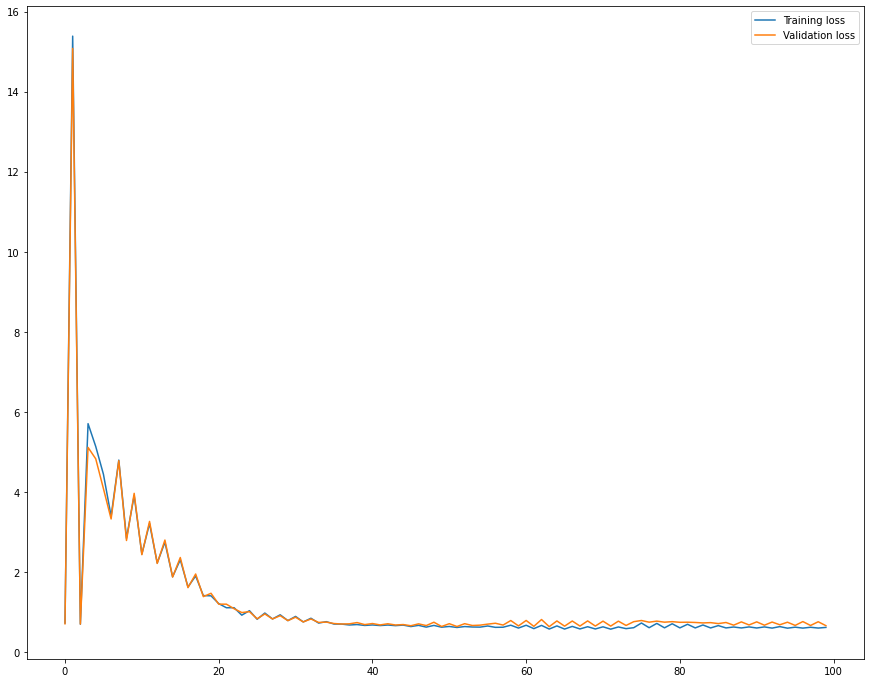

In [12]:
train_ore_detector()

Our goal was to achieve > 60% accuracy to determine if we should move forward with this project. After many attempts adjusting learning rates, number of layers as well as trying dropout layers, only a 50% accuracy was acheived which is not enough to consider this idea worth pursuing in its present form.

Possible ideas to improve the concept:

- More detailed photographs. The photos selected were selected at an arbitrary distance from the Earth's surface, perhaps closer, more detailed photos would provide more information/features for the algorithm to process.

- Using more wavelengths of light. Mineral deposits can be found from photographs using wavelengs of light in or near the infrared spectrum. Including many bands beyond visible light may increase the ability of an algorithm to recognize patterns, but would likely increase the complexity and training time dramatically.
